In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import math
import json
from scipy import stats
from scipy.stats import gaussian_kde
import psycopg2 as psql
from psycopg2.extras import RealDictCursor
from statsmodels.nonparametric.kde import KDEUnivariate

import sys
sys.path.append("..")
from tools.flight_projection import *

import seaborn as sns
sns.set(color_codes=True)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/home/victor/.local/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [4]:
try:
    conn = psql.connect("dbname='thesisdata' user='postgres' host='localhost' password='postgres'")
except Exception as e:
    print("Unable to connect to the database.")
    print(e)

cnt = 0

cur_read = conn.cursor(cursor_factory=RealDictCursor)
cur_read.execute("SELECT cte, ate, tte, time_proj FROM public.projected_flights limit 5000;")

<h2>Distribution of Track Errors over time</h2>
Based on the collection of nominal projections, the Cross-Track error at a specified look-ahead time are aggregated and plotted

In [5]:
# create bin dataframe
la_time = 1200
bin_sec = 20
bin_dp_df = {}
fetch_batch_size = 1000
spd_lim = 30000

while True:
    
    batch = cur_read.fetchmany(size=fetch_batch_size)
    
    if not batch:
        break
    
    for f in batch:
        
        cte_lst = f['cte']
        ate_lst = f['ate']
        tte_lst = f['tte']
        ts_lst = f['time_proj']
            
        for b in range(int(la_time/bin_sec)):
            bmin = b*bin_sec
            bmax = (b+1)*bin_sec
            if str(bmax)+'_cte' not in list(bin_dp_df.keys()):
                bin_dp_df[str(bmax)+'_cte'] = []
            if str(bmax)+'_ate' not in list(bin_dp_df.keys()):
                bin_dp_df[str(bmax)+'_ate'] = []
            if str(bmax)+'_tte' not in list(bin_dp_df.keys()):
                bin_dp_df[str(bmax)+'_tte'] = []
                
            bin_dp_df[str(bmax)+'_cte'].extend([e for e,t in zip(cte_lst, ts_lst) if t >= bmin and t <= bmax and abs(e) < bmax*spd_lim])
            bin_dp_df[str(bmax)+'_ate'].extend([e for e,t in zip(ate_lst, ts_lst) if t >= bmin and t <= bmax and abs(e) < bmax*spd_lim]) 
            bin_dp_df[str(bmax)+'_tte'].extend([e for e,t in zip(tte_lst, ts_lst) if t >= bmin and t <= bmax and abs(e) < bmax*spd_lim]) 
        
cur_read.close()
conn.close()

box_data = []

bin_df = bin_dp_df #set type of error (cp or d)

for k in bin_df.keys():
    if '_cte' in k:
        box_data.append((int(k.strip('_cte')), [i for i in bin_df[k] if not np.isnan(i)]))
    
box_data_sort = sorted(box_data, key=lambda tup: tup[0])
box_data_2 = [i[1] for i in box_data_sort]

x = range(len(box_data_2))


<h2>MC Simulation & Distribution fitting</h2>
Now we fit a second degree polynomial model of the distribution parameters to the look-ahead time.
This we will use for the MC simulations in the probabilistic projection case


In [2]:
def mc_estimate_distr(x_obs):
    x_obs_p = np.nanpercentile(x_obs,99)
    x_obs_filt = [v for v in x_obs if abs(v) < x_obs_p]

    rlim = x_obs_p

    with pm.Model() as model:

        b = pm.Uniform('b', 0,5000)
        a = pm.Uniform('a',-5000,5000)
        cte = pm.Cauchy('cte',alpha=a, beta=b,
                        observed=x_obs)

        x_trace = pm.sample(500,tune=2000)

    a_est = np.mean(x_trace['a'])
    b_est = np.mean(x_trace['b'])
    
    return a_est, b_est


def get_distribution_params(prefix, obs_df):
    
    assert prefix in ['_cte','_ate'], "Prefix not correct"
    
    alpha_est = []
    beta_est = []
    x_la = []

    for k in bin_df.keys():
        if prefix in k:
            x_obs = [x for x in obs_df[k] if ~np.isnan(x)]
            range_lim = np.nanpercentile(x_obs,99)
            x_obs_filt = [x for x in x_obs if abs(x) < range_lim][:2000]

            x_lai = int(k.strip(prefix))
            x_la.append(x_lai)

            print('Estimating for t=%d' % x_lai)

            a_est, b_est = mc_estimate_distr(x_obs_filt)

            alpha_est.append(a_est)
            beta_est.append(b_est)

    from sklearn import linear_model

    x_in = [[1,xx,xx**2] for xx in x_la]
    clf_dict = {}
    param_dict = {}
    param_dict['la_time'] = x_la
    param_dict['alpha'] = alpha_est
    param_dict['beta'] = beta_est
    
    for param in ['alpha','beta']:
        clf_dict[param] = linear_model.LinearRegression()
        clf_dict[param].fit(x_in, param_dict[param])
    
    return param_dict, clf_dict


def plot_est_distr(la_time,x_obs_i,clf_dict):
    
    x_obs_p_i = np.nanpercentile(x_obs_i,99)
    x_obs_filt_i = [v for v in x_obs_i if abs(v) < x_obs_p_i]

    rlim = x_obs_p_i
    
    a_est_i = clf_dict['alpha'].predict([[1,la_time,la_time**2]])
    b_est_i = clf_dict['beta'].predict([[1,la_time,la_time**2]])
    
    sdistr = pm.Cauchy.dist(alpha=a_est_i, beta=b_est_i)
    x_samp = [v for v in sdistr.random(size=100000) if abs(v) < rlim]

    fig, ax = plt.subplots(figsize=(15, 10))
    n_bins = 1000

    n, bins, patches = ax.hist(x_samp, n_bins, normed=0, histtype='stepfilled',
                               cumulative=False, label='CTE distr. at %s seconds' % la_time, alpha=0.6)

    n, bins, patches = ax.hist(x_obs_filt_i, n_bins, normed=0, histtype='stepfilled',
                               cumulative=False, label='CTE distr. at %s seconds' % la_time, alpha=0.6)
    plt.xlim(-rlim,rlim)
    plt.show()
    
    
def realign_conflict(b):
    
    cfl_dst = 9260
    
    for i in range(1,len(b)):
        
        if calc_coord_dst_simple((b['lon_1'][-i],b['lat_1'][-i]),(b['lon_2'][-i],b['lat_2'][-i])) >= cfl_dst:
            for k in ['ts_1','lat_1','lon_1','alt_1','spd_1','hdg_1','roc_1',
                      'ts_2','lat_2','lon_2','alt_2','spd_2','hdg_2','roc_2']:
                b[k] = b[k][:-(i-1)]
            return (b)
    
    return None
        

def time_to_conflict(tr1,tr2):
    
    cfl_dst = 9260
    
    for i in range(len(tr1)):
        cdst = calc_coord_dst_simple((tr1['proj_lat'].iloc[i],
                                  tr1['proj_lon'].iloc[i]),
                                 (tr2['proj_lat'].iloc[i],
                                  tr2['proj_lon'].iloc[i])) 
        print(cdst)
        if cdst <= cfl_dst:
            ttc = tr1['ts'].iloc[i] - tr1['ts'].iloc[0]
            
            return ttc
    
    return None


def ac_dist_stoch(t, cte_1, ate_1, cte_2, ate_2, lat_1, lon_1, lat_2, lon_2, hdg_1, hdg_2, spd_1, spd_2):

    knots_to_ms = 0.514444
    ipz_lim = 9260 #meters

    alpha_1 = heading_diff(calc_compass_bearing((lat_1, lon_1),(lat_2, lon_2)), hdg_1)
    alpha_2 = heading_diff(calc_compass_bearing((lat_2, lon_2),(lat_1, lon_1)), hdg_2)

    gamma = 180 - (alpha_1 + alpha_2)

    if gamma < 0:
        return np.nan
    else:
        dx1_e = math.sin(math.radians(heading_diff(0,hdg_1))) * ate_1 + math.cos(math.radians(heading_diff(0,hdg_1))) * cte_1
        dy1_e = math.sin(math.radians(heading_diff(hdg_1,0))) * cte_1 + math.cos(math.radians(heading_diff(hdg_1,0))) * ate_1
        dx2_e = math.sin(math.radians(heading_diff(0,hdg_2))) * ate_2 + math.cos(math.radians(heading_diff(0,hdg_2))) * cte_2
        dy2_e = math.sin(math.radians(heading_diff(hdg_2,0))) * cte_2 + math.cos(math.radians(heading_diff(hdg_2,0))) * ate_2
        
        dy_1 = math.cos(math.radians(heading_diff(hdg_1,0))) * spd_1 * knots_to_ms + (dy1_e / t)
        dy_2 = math.cos(math.radians(heading_diff(hdg_2,0))) * spd_2 * knots_to_ms + (dy2_e / t)
        dx_1 = math.sin(math.radians(heading_diff(hdg_1,0))) * spd_1 * knots_to_ms + (dx1_e / t)
        dx_2 = math.sin(math.radians(heading_diff(hdg_2,0))) * spd_2 * knots_to_ms + (dx2_e / t)

        dx = abs(dx_1 - dx_2) * t
        dy = abs(dy_1 - dy_2) * t

        s = calc_coord_dst((lat_1, lon_1),(lat_2, lon_2))
        d = s - np.sqrt((dy**2 + dx**2))

        return d
    
def ttc_est(lat_1, lon_1, lat_2, lon_2, hdg_1, hdg_2, spd_1, spd_2):
    
    knots_to_ms = 0.514444
    ipz_lim = 9260 #meters
    
    alpha_1 = heading_diff(calc_compass_bearing((lat_1, lon_1),(lat_2, lon_2)), hdg_1)
    alpha_2 = heading_diff(calc_compass_bearing((lat_2, lon_2),(lat_1, lon_1)), hdg_2)
    
    gamma = 180 - (alpha_1 + alpha_2)
    
    if gamma < 0:
        return np.nan
    else:
        dy_1 = math.cos(math.radians(heading_diff(hdg_1,0))) * spd_1 * knots_to_ms
        dy_2 = math.cos(math.radians(heading_diff(hdg_2,0))) * spd_2 * knots_to_ms
        dx_1 = math.sin(math.radians(heading_diff(hdg_1,0))) * spd_1 * knots_to_ms
        dx_2 = math.sin(math.radians(heading_diff(hdg_2,0))) * spd_2 * knots_to_ms
        
        dx = abs(dx_1 - dx_2)
        dy = abs(dy_1 - dy_2)
        
        s = calc_coord_dst((lat_1, lon_1),(lat_2, lon_2))
        ttc = (s - ipz_lim) / np.sqrt((dy**2 + dx**2))
        
        return ttc
    
    
def create_kde(df,la_t,gsize=100j):
    
    cte_data_raw = [x for x in df['%d_cte' % la_t] if ~np.isnan(x)]
    cte_data_p = np.percentile(cte_data_raw,99)
    cte_data_filt = [v for v in cte_data_raw if abs(v) < cte_data_p][:2000]
    ate_data_raw = [x for x in df['%d_ate' % la_t] if ~np.isnan(x)]
    ate_data_p = np.percentile(ate_data_raw,99)
    ate_data_filt = [v for v in ate_data_raw if abs(v) < ate_data_p][:2000]

    data = np.vstack([cte_data_filt,ate_data_filt])
    X,Y = np.mgrid[min(cte_data_filt):max(cte_data_filt):gsize, min(ate_data_filt):max(ate_data_filt):gsize]
    grid = np.vstack([Y.ravel(), X.ravel()])
    kde = gaussian_kde(data, bw_method=20/np.std(data))
#     pdf = kde(grid)
    
    return kde

In [ ]:
cte_param_dict, cte_clf_dict = get_distribution_params('_cte', bin_df)
ate_param_dict, ate_clf_dict = get_distribution_params('_ate', bin_df)

# plt.scatter(x_la, cte_clf_dict[param].predict(x_in), color='r')
# plt.scatter(x_la,cte_param_dict[param])
# plt.show()

In [ ]:
la_t = 160
x_obs = [x for x in bin_df['%d_ate' % la_t] if ~np.isnan(x)]
plot_est_distr(la_t, x_obs, ate_clf_dict)

x_obs = [x for x in bin_df['%d_cte' % la_t] if ~np.isnan(x)]
plot_est_distr(la_t, x_obs, cte_clf_dict)

<h2>Sample A/C distance distribution</h2>

In [11]:
try:
    conn = psql.connect("dbname='thesisdata' user='postgres' host='localhost' password='postgres'")
except Exception as e:
    print("Unable to connect to the database.")
    print(e)

cur_read = conn.cursor(cursor_factory=RealDictCursor)
cur_read.execute("SELECT * FROM public.conflicts limit 1;")
batch = cur_read.fetchall()

cfl_dst = 9260
for b in batch:

    try:
        b = realign_conflict(b)
    except Exception as e:
        print('Error in realigning Conflict')
        b = None
        
    if b:
        b['ettc'] = []
        b['ttc'] = []
        b['ecpa'] = []

        fl1 = pd.DataFrame()
        fl1['lat'] = b['lat_1']
        fl1['lon'] = b['lon_1']
        fl1['ts'] = b['ts_1']
        fl1['hdg'] = b['hdg_1']
        fl1['spd'] = b['spd_1']

        fl2 = pd.DataFrame()
        fl2['lat'] = b['lat_2']
        fl2['lon'] = b['lon_2']
        fl2['ts'] = b['ts_2']
        fl2['hdg'] = b['hdg_2']
        fl2['spd'] = b['spd_2']


        for t in range(len(b['ts_1'])):
            try:
                ttc_i = b['ts_1'][-1] - b['ts_1'][t]
                b['ttc'].append(ttc_i)
            except:
                print(b)
                
                
            print(ttc_i)
            cte_a_est_i = cte_clf_dict['alpha'].predict([[1,ttc_i,ttc_i**2]])
            cte_b_est_i = cte_clf_dict['beta'].predict([[1,ttc_i,ttc_i**2]])
            cte_distr = pm.Cauchy.dist(alpha=cte_a_est_i, beta=cte_b_est_i)
            
            ate_a_est_i = ate_clf_dict['alpha'].predict([[1,ttc_i,ttc_i**2]])
            ate_b_est_i = ate_clf_dict['beta'].predict([[1,ttc_i,ttc_i**2]])
            ate_distr = pm.Cauchy.dist(alpha=ate_a_est_i, beta=ate_b_est_i)
            
            draw_list = []
            
            for ti in [tt for tt in range(int(ttc_i)-60,int(ttc_i)+60) if tt > 0]:
                te_dist = [(cte_distr.random(size=1),ate_distr.random(size=1)) for i in range(0,100)]
                draws = [ac_dist_stoch(ti, cte, ate, fl1['lat'][t], fl1['lon'][t], fl2['lat'][t], fl2['lon'][t], 
                                     fl1['hdg'][t], fl2['hdg'][t], fl1['spd'][t], fl2['spd'][t]) for (cte,ate) in te_dist]
                draw_list.append((ti,np.mean(draws)))
            
            break
#             b['ettc'].append(
        
        b['ttc_diff'] = [x-y for x,y in zip(b['ttc'],b['ettc'])]
            
            
        for tt in range(int(la_time/bin_sec)):
            bmin = tt*bin_sec
            bmax = (tt+1)*bin_sec
            if str(bmax) not in list(bin_dp_df.keys()):
                bin_dp_df[str(bmax)] = []
                
            bin_dp_df[str(bmax)].extend([e for e,t in zip(b['ttc_diff'], b['ttc']) 
                                                if t >= bmin and t <= bmax])

        plt.plot(b['ttc'], b['ettc'])
# plt.show()


277.0


NameError: name 'cte_clf_dict' is not defined

<h2>Kernel Density based Estimate of error distribution</h2>

<h3>Create list of KDE estimators</h3>

In [6]:
pdf_dict = {}

print('Creating kde estimators')
for la_ti in [i*20 for i in range(1,61)]:
    pdf_dict[str(la_ti)] = create_kde(bin_df,la_ti)

Creating kde estimators


<h3>Estimate TTC based on KDE</h3>

In [8]:
try:
    conn = psql.connect("dbname='thesisdata' user='postgres' host='localhost' password='postgres'")
except Exception as e:
    print("Unable to connect to the database.")
    print(e)

cur_read = conn.cursor(cursor_factory=RealDictCursor)
cur_read.execute("SELECT * FROM public.conflicts;")
batch = cur_read.fetchall()

cfl_dst = 9260
cnt = 0

for b in batch:

    try:
        b = realign_conflict(b)
    except Exception as e:
        print('Error in realigning Conflict')
        b = None
        
    if b:
        
        cnt = cnt + 1
        print('Flight: %d' % cnt)
        
        b['ettc'] = []
        b['ttc'] = []
        b['ecpa'] = []

        fl1 = pd.DataFrame()
        fl1['lat'] = b['lat_1']
        fl1['lon'] = b['lon_1']
        fl1['ts'] = b['ts_1']
        fl1['hdg'] = b['hdg_1']
        fl1['spd'] = b['spd_1']

        fl2 = pd.DataFrame()
        fl2['lat'] = b['lat_2']
        fl2['lon'] = b['lon_2']
        fl2['ts'] = b['ts_2']
        fl2['hdg'] = b['hdg_2']
        fl2['spd'] = b['spd_2']


        for t in range(len(b['ts_1'])):
            try:
                ttc_i = b['ts_1'][-1] - b['ts_1'][t]
                b['ttc'].append(ttc_i)
            except:
                print(b)
            
            draw_list = []
            draw_list_mean=[]
            base = 20
            
            print(ttc_i)
            
            for ti in [tt for tt in range(int(ttc_i)-180,int(ttc_i)+180) if tt > 0]:
                
                la_t = max(int(round(ti/base)*base),20)
                
                te_dist_1 = pdf_dict[str(la_t)].resample(100).reshape(-1,2)
                te_dist_2 = pdf_dict[str(la_t)].resample(100).reshape(-1,2)
                
                te_dist = [(te_dist_1[i][0],te_dist_1[i][1],te_dist_2[i][0],te_dist_2[i][1]) 
                           for i in range(len(te_dist_1))]
                
                draws = [ac_dist_stoch(ti, cte_1,ate_1,cte_2,ate_2, fl1['lat'][t], fl1['lon'][t], 
                                       fl2['lat'][t], fl2['lon'][t], fl1['hdg'][t], fl2['hdg'][t], 
                                       fl1['spd'][t], fl2['spd'][t]) 
                         for (cte_1,ate_1,cte_2,ate_2) in te_dist]
                
                draw_list_mean.append((ti,np.mean(draws)))
                draw_list.append((ti,draws))
            
            try:
                b['ettc'].append([v[0] for v in draw_list_mean if v[1] >= cfl_dst][-1])
            except:
                b['ettc'].append(np.nan)
        
        b['ttc_diff'] = [x-y for x,y in zip(b['ttc'],b['ettc'])]
            
            
        for tt in range(int(la_time/bin_sec)):
            bmin = tt*bin_sec
            bmax = (tt+1)*bin_sec
            if str(bmax) not in list(bin_dp_df.keys()):
                bin_dp_df[str(bmax)] = []
                
            bin_dp_df[str(bmax)].extend([e for e,t in zip(b['ttc_diff'], b['ttc']) 
                                                if t >= bmin and t <= bmax])

#  plt.plot(b['ttc'], b['ettc'])
# plt.show()


Flight: 1
277.0
245.0
238.0
233.0
231.0
230.0
227.0
217.0
216.0
215.0
205.0
202.0
200.0
149.0
144.0
107.0
103.0
82.0
81.0
80.0
52.0
52.0
46.0
45.0
40.0
39.0
37.0
35.0
27.0
26.0
25.0
11.0
9.0
8.0
3.0
1.0
0.0
Flight: 2
689.0
637.0
428.0
407.0
402.0
361.0
341.0
337.0
336.0
303.0
300.0
279.0
276.0
260.0
254.0
246.0
245.0
244.0
239.0
235.0
234.0
227.0
224.0
222.0
218.0
211.0
209.0
201.0
200.0
199.0
194.0
193.0
192.0
168.0
167.0
163.0
163.0
161.0
160.0
157.0
157.0
154.0
153.0
153.0
152.0
150.0
149.0
148.0
145.0
143.0
140.0
138.0
135.0
130.0
129.0
126.0
126.0
123.0
122.0
119.0
118.0
117.0
114.0
111.0
109.0
109.0
103.0
91.0
89.0
87.0
85.0
82.0
78.0
76.0
75.0
73.0
72.0
71.0
70.0
69.0
69.0
62.0
62.0
56.0
52.0
51.0
51.0
42.0
32.0
30.0
28.0
27.0
26.0
25.0
24.0
17.0
16.0
14.0
13.0
12.0
9.0
8.0
7.0
6.0
4.0
4.0
1.0
0.0
Flight: 3
350.0
305.0
292.0
290.0
282.0
276.0
268.0
265.0
241.0
239.0
239.0
238.0
228.0
227.0
226.0
220.0
219.0
182.0
180.0
154.0
152.0
137.0
117.0
107.0
106.0
105.0
101.0
90.0
88.0
67

KeyboardInterrupt: 

In [195]:
ac_dist_stoch(190, 10, 0, fl1['lat'][t], fl1['lon'][t], fl2['lat'][t], fl2['lon'][t], 
                                     fl1['hdg'][t], fl2['hdg'][t], fl1['spd'][t], fl2['spd'][t])

-1.9594614424251757
-3.891239501402064


9218.826121582144

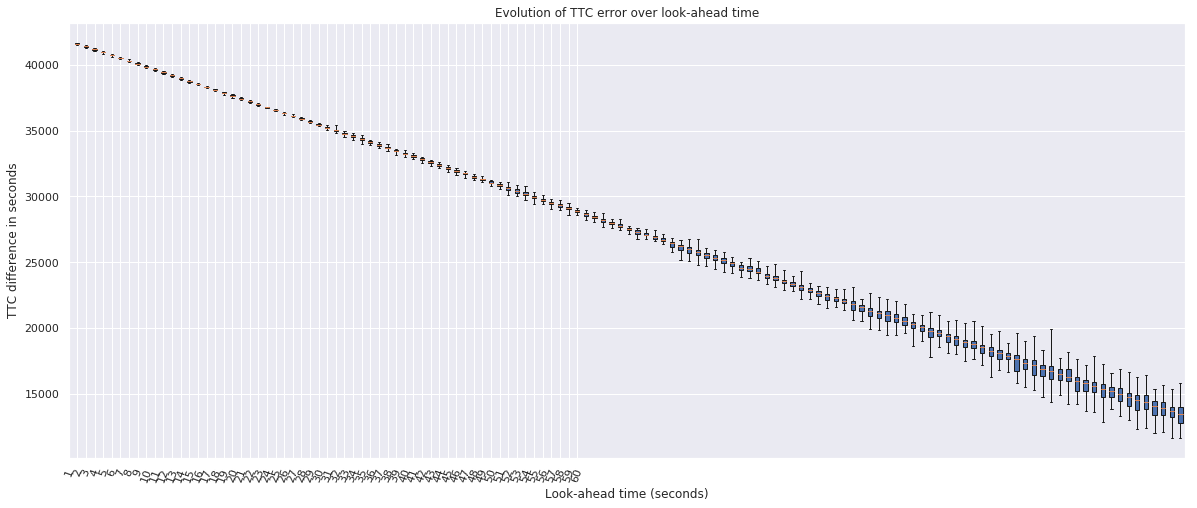

In [9]:
plt.figure(figsize=(20,8))
plt.boxplot([i[1] for i in draw_list], showfliers=False, patch_artist=True, whis=[5,95])
plt.xticks(x, [i[0] for i in draw_list])
plt.xticks(rotation=70)
plt.xlabel('Look-ahead time (seconds)')
plt.ylabel('TTC difference in seconds')
plt.title('Evolution of TTC error over look-ahead time')
plt.show()

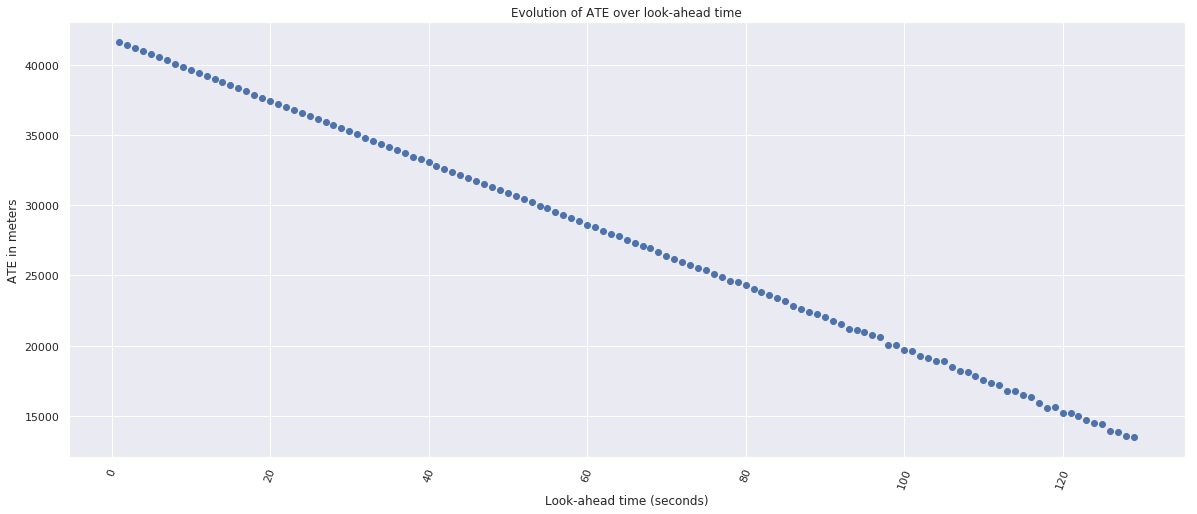

In [10]:
draw_data_sort = sorted(draw_list_mean, key=lambda tup: tup[0])
draw_data_2 = [i[1] for i in draw_list_mean]

x = range(len(draw_data_2))

plt.figure(figsize=(20,8))
# plt.scatter([i[0] for i in draw_list],[i[1] for i in draw_list])
plt.scatter([i[0] for i in draw_list_mean],[i[1] for i in draw_list_mean])
plt.xticks(rotation=70)
plt.xlabel('Look-ahead time (seconds)')
plt.ylabel('ATE in meters')
plt.title('Evolution of ATE over look-ahead time')
plt.show()

In [ ]:
plt.figure(figsize=(20,20))
for ttc_i in [1000,200,60]:

    cte_a_est_i = cte_clf_dict['alpha'].predict([[1,ttc_i,ttc_i**2]])
    cte_b_est_i = cte_clf_dict['beta'].predict([[1,ttc_i,ttc_i**2]])
    cte_distr = pm.Cauchy.dist(alpha=cte_a_est_i, beta=cte_b_est_i)

    ate_a_est_i = ate_clf_dict['alpha'].predict([[1,ttc_i,ttc_i**2]])
    ate_b_est_i = ate_clf_dict['beta'].predict([[1,ttc_i,ttc_i**2]])
    ate_distr = pm.Cauchy.dist(alpha=ate_a_est_i, beta=ate_b_est_i)

    # te_dist = [(cte_distr.random(size=1),ate_distr.random(size=1)) for i in range(0,1000)]

    
    plt.scatter(cte_distr.random(size=50000),ate_distr.random(size=50000), alpha=0.6, s=2)
    plt.xlim(-20000,20000)
    plt.ylim(-20000,20000)

plt.show()

/home/victor/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/victor/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


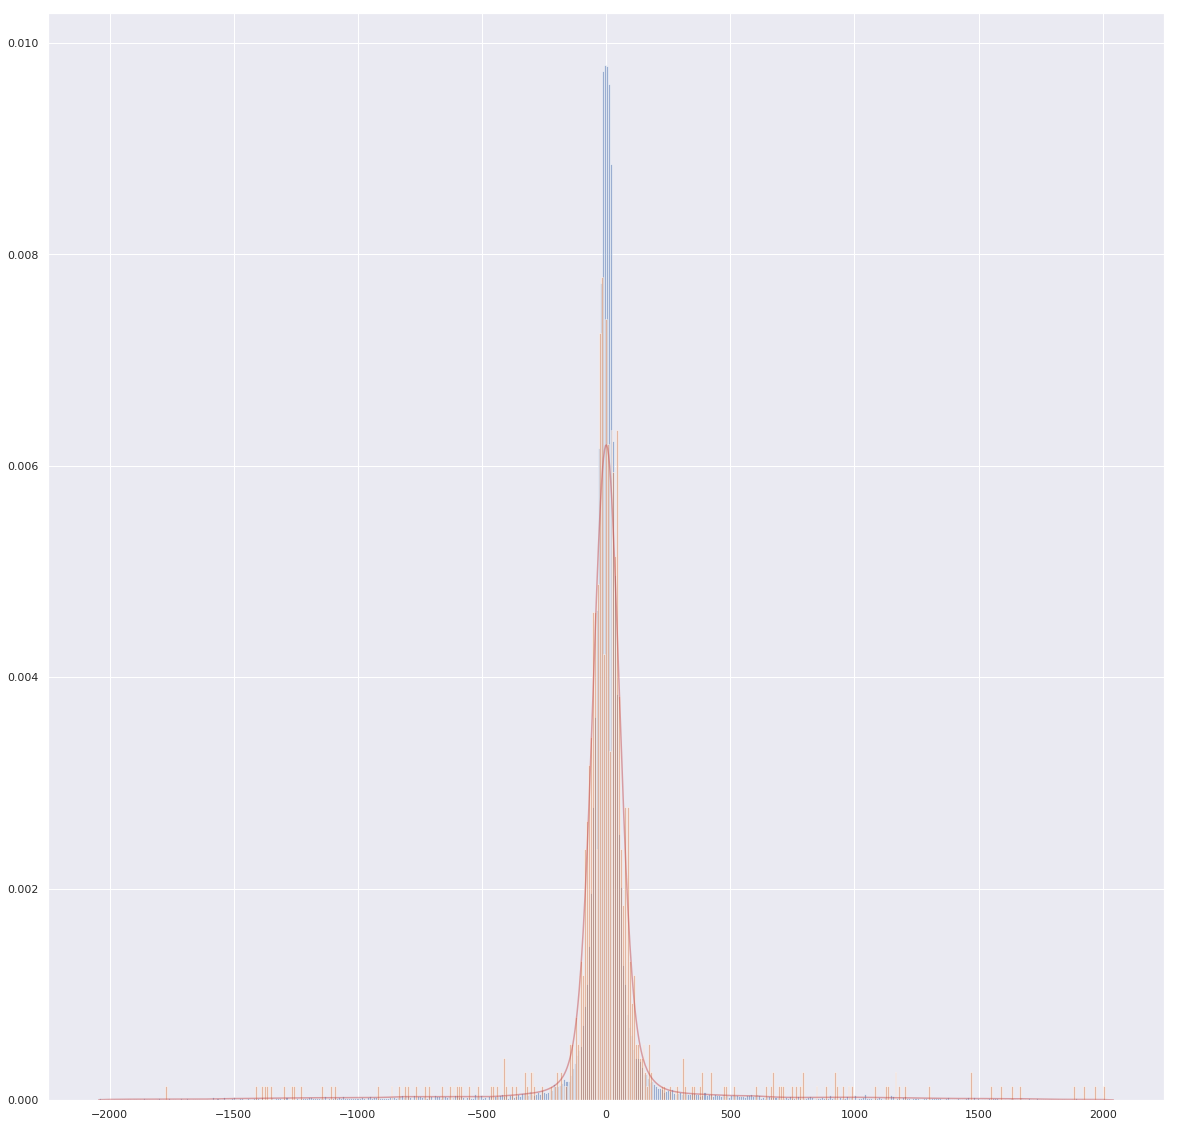

In [20]:

import time

def generate_rand_from_pdf(pdf, x_grid):
    cdf = np.cumsum(pdf)
    cdf = cdf / cdf[-1]
    values = np.random.rand(1000)
    value_bins = np.searchsorted(cdf, values)
    random_from_cdf = x_grid[value_bins]
    return random_from_cdf

la_t = 60

cte_data_raw = [x for x in bin_df['%d_cte' % la_t] if ~np.isnan(x)]
cte_data_p = np.percentile(cte_data_raw,99)
ate_data_raw = [x for x in bin_df['%d_ate' % la_t] if ~np.isnan(x)]
ate_data_p = np.percentile(ate_data_raw,99)

data = [v for v in cte_data_raw if abs(v) < cte_data_p]

x_grid = np.linspace(min(data), max(data), 1000)
bandwidth = (la_t-19)
kde = gaussian_kde(data, bw_method=bandwidth / np.std(data))
kdepdf = kde.evaluate(x_grid)
random_from_kde = generate_rand_from_pdf(kdepdf, x_grid)

plt.figure(figsize=(20,20))
plt.hist(data, 500, normed=True, alpha=0.5, label='hist')
plt.hist(random_from_kde, 500, normed=True, alpha=0.5, label='hist')
plt.plot(x_grid, kdepdf, color='r', alpha=0.5, label='kde')
plt.show()

In [285]:
from scipy.stats import gaussian_kde
import time

la_t = 1200

cte_data_raw = [x for x in bin_df['%d_cte' % la_t] if ~np.isnan(x)]
cte_data_p = np.percentile(cte_data_raw,99)
cte_data_filt = [v for v in cte_data_raw if abs(v) < cte_data_p][:2000]
ate_data_raw = [x for x in bin_df['%d_ate' % la_t] if ~np.isnan(x)]
ate_data_p = np.percentile(ate_data_raw,99)
ate_data_filt = [v for v in ate_data_raw if abs(v) < ate_data_p][:2000]

data = np.vstack([cte_data_filt,ate_data_filt])
X,Y = np.mgrid[min(cte_data_filt):max(cte_data_filt):200j, min(ate_data_filt):max(ate_data_filt):200j]
grid = np.vstack([Y.ravel(), X.ravel()])
kde = gaussian_kde(data, bw_method=0.1)
pdf = kde(grid)
f = np.reshape(pdf.T, X.shape)


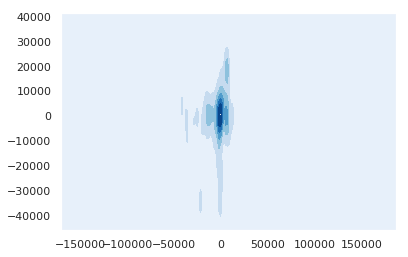

In [286]:
fig = plt.figure()
ax = fig.gca()
ax.set_xlim(min(cte_data_filt), max(cte_data_filt))
ax.set_ylim(min(ate_data_filt), max(ate_data_filt))
# Contourf plot
cfset = ax.contourf(X, Y, f, cmap='Blues')

In [ ]:
list(zip([v for v in cte_data_raw if abs(v) < cte_data_p][:2000],[v for v in ate_data_raw if abs(v) < ate_data_p][:2000]))

In [ ]:
x_mean = []
x_std = []
x_kurt = []
x_skew = []
x_99pct = []
x_la = []

for k in bin_df.keys():
    if '_cte' in k:
        range_lim = 500000
        xtst = [x for x in bin_df[k] if ~np.isnan(x) and abs(x) < range_lim]
        std = np.nanstd(xtst)
        xmean = np.nanmean(xtst)
#         xtst = [(x-xmean)/xstd for x in xtst]
        
        x_la.append(int(k.strip('_cte')))
        x_mean.append(xmean)
        x_std.append(std)
        x_kurt.append(stats.kurtosis(xtst))
        x_skew.append(stats.skew(xtst))
        x_90pct.append(np.nanpercentile(xtst,90))

from sklearn import linear_model
import pymc3 as pm

x_in = [[1,xx,xx**2] for xx in x_la]
clf_dict = {}
param_dict = {}
param_dict['std'] = x_std
param_dict['mean'] = x_mean
param_dict['skew'] = x_skew
param_dict['skew'] = x_skew

for param in ['std','mean','skew']:
    clf_dict[param] = linear_model.LinearRegression()
    clf_dict[param].fit(x_in,param_dict[param])

    plt.scatter(x_la, clf_dict[param].predict(x_in), color='r')
    plt.scatter(x_la,param_dict[param])
    plt.show()

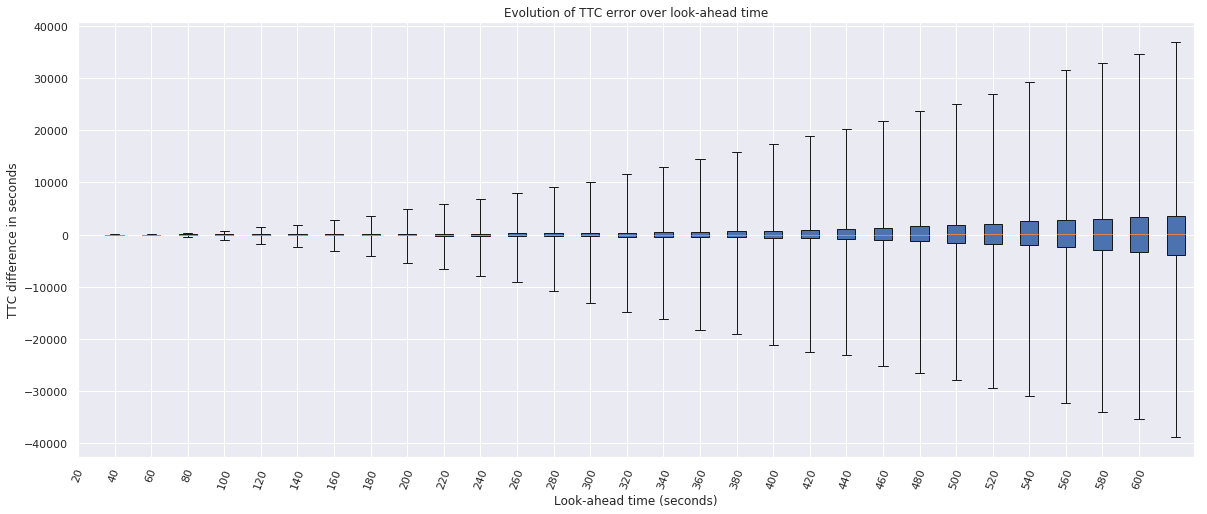

In [23]:
bin_df = bin_dp_df
box_data = []
box_data_sort = []

for k in [kx for kx in bin_df.keys() if 'cte' in kx and int(kx.strip('_cte')) <= 600]:
    box_data.append((int(k.strip('_cte')), [i for i in bin_df[k] if not np.isnan(i)]))
    
box_data_sort = sorted(box_data, key=lambda tup: tup[0])
box_data_2 = [i[1] for i in box_data_sort]

x = range(len(box_data_2))

plt.figure(figsize=(20,8))
plt.boxplot(box_data_2, showfliers=False, patch_artist=True, whis=[5,95])
plt.xticks(x, [i[0] for i in box_data_sort])
plt.xticks(rotation=70)
plt.xlabel('Look-ahead time (seconds)')
plt.ylabel('TTC difference in seconds')
plt.title('Evolution of TTC error over look-ahead time')
plt.show()

In [29]:
len(box_data_2[20])

38507

In [ ]:
cur_read.close()

conn.close()